# Conditional Autoencoder for Asset Pricing - Part 2: The Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


This notebook uses a dataset created using `yfinance` in the notebook [conditional_autoencoder_for_asset_pricing_data](05_conditional_autoencoder_for_asset_pricing_data.ipynb). The results will vary depending on which ticker downloads succeeded.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import sys, os
from time import time
from pathlib import Path
from itertools import product
from tqdm import tqdm 

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dot, Reshape, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard

from sklearn.preprocessing import quantile_transform

from scipy.stats import spearmanr

In [ ]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


In [ ]:
import os

# Get the current working directory
path = os.getcwd()

# Print the path
print("Current Path:", path)

# 이동할 디렉토리 경로
path = '/content/drive/MyDrive/Colab Notebooks'

# 디렉토리 변경
os.chdir(path)

Current Path: /content


In [ ]:
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import MultipleTimeSeriesCV, format_time

In [ ]:
idx = pd.IndexSlice
sns.set_style('whitegrid')
np.random.seed(42)

In [ ]:
results_path = Path('results', 'asset_pricing')
if not results_path.exists():
    results_path.mkdir(parents=True)

In [ ]:
characteristics = ['beta', 'betasq', 'chmom', 'dolvol', 'idiovol', 'ill', 'indmom',
                   'maxret', 'mom12m', 'mom1m', 'mom36m', 'mvel', 'retvol', 'turn', 'turn_std']

## Load Data

In [ ]:
with pd.HDFStore(results_path / 'autoencoder.h5') as store:
    print(store.info())

<class 'pandas.io.pytables.HDFStore'>
File path: results/asset_pricing/autoencoder.h5
/close                      frame        (shape->[7559,3825]) 
/factor/beta                frame        (shape->[2677781,1]) 
/factor/betasq              frame        (shape->[2677781,1]) 
/factor/chmom               frame        (shape->[3032594,1]) 
/factor/dolvol              frame        (shape->[3194404,1]) 
/factor/idiovol             frame        (shape->[2677781,1]) 
/factor/ill                 frame        (shape->[2880851,1]) 
/factor/indmom              frame        (shape->[3182400,1]) 
/factor/maxret              frame        (shape->[3194850,1]) 
/factor/mom12m              frame        (shape->[3032594,1]) 
/factor/mom1m               series       (shape->[3210620])   
/factor/mom36m              frame        (shape->[2676077,1]) 
/factor/mvel                frame        (shape->[3227144,1]) 
/factor/retvol              frame        (shape->[3210620,1]) 
/factor/turn                fram

### Weekly returns

In [ ]:
data = (pd.read_hdf(results_path / 'autoencoder.h5', 'returns')
        .stack(dropna=False)
        .to_frame('returns')
        .loc[idx['1993':, :], :])

# 램 문제 발생으로 인한 1993 -> 2013

In [ ]:
with pd.HDFStore(results_path / 'autoencoder.h5') as store:
    keys = [k[1:] for k in store.keys() if k[1:].startswith('factor')]
    for key in keys:
        data[key.split('/')[-1]] = store[key].squeeze()

In [ ]:
characteristics = data.drop('returns', axis=1).columns.tolist()

In [ ]:
data['returns_fwd'] = data.returns.unstack('ticker').shift(-1).stack()

In [ ]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5393250 entries, (Timestamp('1993-01-01 00:00:00', freq='W-FRI'), 'A') to (Timestamp('2020-01-03 00:00:00', freq='W-FRI'), 'ZYXI')
Data columns (total 17 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   returns      3091645 non-null  float64
 1   beta         2677781 non-null  float64
 2   betasq       2677781 non-null  float64
 3   chmom        2947392 non-null  float64
 4   dolvol       3069376 non-null  float64
 5   idiovol      2677781 non-null  float64
 6   ill          2785453 non-null  float64
 7   indmom       3091645 non-null  float64
 8   maxret       3069822 non-null  float64
 9   mom12m       2947392 non-null  float64
 10  mom1m        3081787 non-null  float64
 11  mom36m       2676077 non-null  float64
 12  mvel         3094437 non-null  float64
 13  retvol       3081787 non-null  float64
 14  turn         3056929 non-null  float64
 15  turn_std     3077284 non-null  fl

In [ ]:
nobs_by_date = data.groupby(level='date').count().max(1)
nobs_by_characteristic = pd.melt(data[characteristics].groupby(level='date').count(),
                                 value_name='# Observations',
                                 var_name=['Characteristic'])

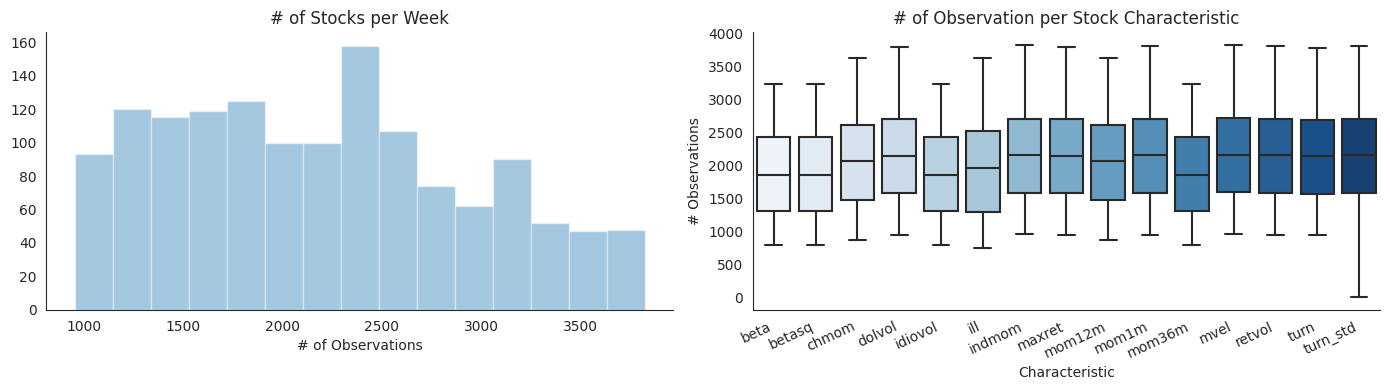

In [ ]:
with sns.axes_style("white"):
    fig, axes = plt.subplots(ncols=2, figsize=(14, 4))
    sns.distplot(nobs_by_date, kde=False, ax=axes[0])
    axes[0].set_title('# of Stocks per Week')
    axes[0].set_xlabel('# of Observations')
    sns.boxplot(x='Characteristic',
                y='# Observations',
                data=nobs_by_characteristic,
                ax=axes[1],
                palette='Blues')
    axes[1].set_xticklabels(axes[1].get_xticklabels(),
                            rotation=25,
                            ha='right')
    axes[1].set_title('# of Observation per Stock Characteristic')
    sns.despine()
    fig.tight_layout()
    # fig.savefig(results_path / 'of Stocks per Week', dpi=600)

### Rank-normalize characteristics

In [ ]:
data.loc[:, characteristics] = (data.loc[:, characteristics]
                                .groupby(level='date')
                                .apply(lambda x: pd.DataFrame(quantile_transform(x, 
                                                                                 copy=True, 
                                                                                 n_quantiles=x.shape[0]),
                                                              columns=characteristics,
                                                              index=x.index.get_level_values('ticker')))
                               .mul(2).sub(1))

In [ ]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5393250 entries, (Timestamp('1993-01-01 00:00:00', freq='W-FRI'), 'A') to (Timestamp('2020-01-03 00:00:00', freq='W-FRI'), 'ZYXI')
Data columns (total 17 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   returns      3091645 non-null  float64
 1   beta         2677781 non-null  float64
 2   betasq       2677781 non-null  float64
 3   chmom        2947392 non-null  float64
 4   dolvol       3069376 non-null  float64
 5   idiovol      2677781 non-null  float64
 6   ill          2785453 non-null  float64
 7   indmom       3091645 non-null  float64
 8   maxret       3069822 non-null  float64
 9   mom12m       2947392 non-null  float64
 10  mom1m        3081787 non-null  float64
 11  mom36m       2676077 non-null  float64
 12  mvel         3094437 non-null  float64
 13  retvol       3081787 non-null  float64
 14  turn         3056929 non-null  float64
 15  turn_std     3077284 non-null  fl

In [ ]:
data.index.names

FrozenList(['date', 'ticker'])

In [ ]:
data.describe()

,returns,beta,betasq,chmom,dolvol,idiovol,ill,indmom,maxret,mom12m,mom1m,mom36m,mvel,retvol,turn,turn_std,returns_fwd
count,3.091645e+06,2.677781e+06,2.677781e+06,2.947392e+06,3.069376e+06,2.677781e+06,2.785453e+06,3.091645e+06,3.069822e+06,2.947392e+06,3.081787e+06,2.676077e+06,3.094437e+06,3.081787e+06,3.056929e+06,3.077284e+06,3.090691e+06
mean,3.045176e-03,-5.309169e-08,-5.146152e-07,6.963426e-09,-4.709343e-07,-2.391944e-07,-5.998247e-07,7.947761e-04,-1.238270e-07,-1.101284e-07,3.994020e-08,-1.678374e-07,-3.933234e-08,-1.024869e-06,-4.668285e-07,-9.886441e-07,3.042616e-03
std,6.134996e-02,5.776538e-01,5.776544e-01,5.776258e-01,5.776161e-01,5.776539e-01,5.776421e-01,5.879197e-01,5.776144e-01,5.776259e-01,5.776114e-01,5.776540e-01,5.776128e-01,5.776155e-01,5.776164e-01,5.776150e-01,6.135423e-02
min,-9.549180e-01,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-9.549180e-01
25%,-2.155692e-02,-5.002539e-01,-5.002617e-01,-5.002054e-01,-5.001815e-01,-5.002382e-01,-5.002250e-01,-4.900628e-01,-5.002588e-01,-5.002046e-01,-5.000749e-01,-5.002558e-01,-5.001877e-01,-5.001996e-01,-5.001927e-01,-5.001929e-01,-2.156144e-02
50%,9.764409e-04,0.000000e+00,0.000000e+00,0.000000e+00,-1.110223e-16,-1.110223e-16,0.000000e+00,1.046025e-03,0.000000e+00,0.000000e+00,-1.110223e-16,0.000000e+00,-1.110223e-16,-1.110223e-16,0.000000e+00,0.000000e+00,9.764634e-04
75%,2.502054e-02,5.002418e-01,5.002408e-01,5.002116e-01,5.001990e-01,5.002417e-01,5.002108e-01,4.811715e-01,5.001784e-01,5.002182e-01,5.001866e-01,5.002496e-01,5.001930e-01,5.001858e-01,5.001975e-01,5.001834e-01,2.501880e-02
max,4.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,4.000000e+00


In [ ]:
data = data.loc[idx[:'2019', :], :]

In [ ]:
data.loc[:, ['returns', 'returns_fwd']] = data.loc[:, ['returns', 'returns_fwd']].clip(lower=-1, upper=1.0)

In [ ]:
data = data.fillna(-2)

In [ ]:
data.to_hdf(results_path / 'autoencoder.h5', 'model_data')

## Architecture

In [ ]:
data = pd.read_hdf(results_path / 'autoencoder.h5', 'model_data')

### Key parameters

In [ ]:
n_factors = 3
n_characteristics = len(characteristics)
n_tickers = len(data.index.unique('ticker'))

In [ ]:
n_tickers

3825

In [ ]:
n_characteristics

15

### Input Layer

In [ ]:
input_beta = Input((n_tickers, n_characteristics), name='input_beta')
input_factor = Input((n_tickers,), name='input_factor')

### Stock Characteristics Network

In [ ]:
hidden_layer = Dense(units=8, activation='relu', name='hidden_layer')(input_beta)
batch_norm = BatchNormalization(name='batch_norm')(hidden_layer)
output_beta = Dense(units=n_factors, name='output_beta')(batch_norm)

### Factor Network

In [ ]:
output_factor = Dense(units=n_factors, name='output_factor')(input_factor)

### Output Layer

In [ ]:
output = Dot(axes=(2,1), name='output_layer')([output_beta, output_factor])

### Compile Layer

In [ ]:
model = Model(inputs=[input_beta, input_factor], outputs=output)
model.compile(loss='mse', optimizer='adam')

### Automate model generation

In [ ]:
def make_model(hidden_units=8, n_factors=3):
    input_beta = Input((n_tickers, n_characteristics), name='input_beta')
    input_factor = Input((n_tickers,), name='input_factor')

    hidden_layer = Dense(units=hidden_units, activation='relu', name='hidden_layer')(input_beta)
    batch_norm = BatchNormalization(name='batch_norm')(hidden_layer)
    
    output_beta = Dense(units=n_factors, name='output_beta')(batch_norm)

    output_factor = Dense(units=n_factors, name='output_factor')(input_factor)

    output = Dot(axes=(2,1), name='output_layer')([output_beta, output_factor])

    model = Model(inputs=[input_beta, input_factor], outputs=output)
    model.compile(loss='mse', optimizer='adam')
    return model

### Model Summary

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_beta (InputLayer)        [(None, 3825, 15)]   0           []                               
                                                                                                  
 hidden_layer (Dense)           (None, 3825, 8)      128         ['input_beta[0][0]']             
                                                                                                  
 batch_norm (BatchNormalization  (None, 3825, 8)     32          ['hidden_layer[0][0]']           
 )                                                                                                
                                                                                                  
 input_factor (InputLayer)      [(None, 3825)]       0           []                           

### 모델 시각화

In [ ]:
# model_img_file = (results_path / 'model.png' )
# tf.keras.utils.plot_model(model, to_file=model_img_file, 
#                           show_shapes=True, 
#                           show_layer_activations=True, 
#                           show_dtype=True,
#                           show_layer_names=True )

# model.save(results_path / 'model_img.h5')

## Train Model

### Cross-validation parameters

In [ ]:
YEAR = 52

In [ ]:
cv = MultipleTimeSeriesCV(n_splits=5, # 5
                          train_period_length=20*YEAR,
                          test_period_length=1*YEAR,
                          lookahead=1)

In [ ]:
def get_train_valid_data(data, train_idx, val_idx):
    train, val = data.iloc[train_idx], data.iloc[val_idx]
    X1_train = train.loc[:, characteristics].values.reshape(-1, n_tickers, n_characteristics)
    X1_val = val.loc[:, characteristics].values.reshape(-1, n_tickers, n_characteristics)
    X2_train = train.loc[:, 'returns'].unstack('ticker')
    X2_val = val.loc[:, 'returns'].unstack('ticker')
    y_train = train.returns_fwd.unstack('ticker')
    y_val = val.returns_fwd.unstack('ticker')
    return X1_train, X2_train, y_train, X1_val, X2_val, y_val

### Hyperparameter Options

In [ ]:
factor_opts = [2, 3, 4, 5, 6] # 2, 3, 4, 5, 6
unit_opts = [8, 16, 32] # 8, 16, 32

In [ ]:
param_grid = list(product(unit_opts, factor_opts))

### Run Cross-Validation

In [ ]:
batch_size = 256

In [ ]:
cols = ['units', 'n_factors', 'fold', 'epoch', 'ic_mean', 
        'ic_daily_mean', 'ic_daily_std', 'ic_daily_median']

In [ ]:
import gc
from tensorflow.keras import backend as k
from tensorflow.keras.callbacks import Callback
from keras.utils import Sequence

# Define a custom data generator to feed data to the model
class DataGenerator(Sequence):
    def __init__(self, X1, X2, y, batch_size):
        self.X1 = X1
        self.X2 = X2
        self.y = y
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.X1) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_X1 = self.X1[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_X2 = self.X2[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return [batch_X1, batch_X2], batch_y

class ClearMemory(Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
        k.clear_session()

In [ ]:
start = time()
for units, n_factors in param_grid:
    units = 8
    n_factors = 6
    print("units:", units, ", n_factors:", n_factors)
    scores = []
    for fold, (train_idx, val_idx) in enumerate(cv.split(data)):
        X1_train, X2_train, y_train, X1_val, X2_val, y_val = get_train_valid_data(data,
                                                                                  train_idx,
                                                                                  val_idx)
        train_gen = DataGenerator(X1_train, X2_train, y_train, batch_size=batch_size)
        val_gen = DataGenerator(X1_val, X2_val, y_val, batch_size=batch_size)
        model = make_model(hidden_units=units, n_factors=n_factors)
        for epoch in range(250):
            model.fit_generator(train_gen,
                                validation_data=val_gen,
                                epochs=epoch + 1,
                                initial_epoch=epoch, verbose=False, shuffle=True, callbacks=ClearMemory())
            y_pred = model.predict_generator(val_gen, callbacks=ClearMemory())
            y_true = y_val.stack().values
            date_index = y_val.stack().index
            result = (pd.DataFrame({'y_pred': y_pred.reshape(-1),
                                    'y_true': y_true},
                                   index=date_index)
                      .replace(-2, np.nan).dropna())
            r0 = spearmanr(result.y_true, result.y_pred)[0]
            r1 = result.groupby(level='date').apply(lambda x: spearmanr(x.y_pred,
                                                                        x.y_true)[0])

            scores.append([units, n_factors, fold, epoch, r0,
                           r1.mean(), r1.std(), r1.median()])
            if epoch % 50 == 0:
                print(f'{format_time(time()-start)} | {n_factors} | {units:02} | {fold:02}-{epoch:03} | {r0:6.2%} | '
                  f'{r1.mean():6.2%} | {r1.median():6.2%}')
            
        scores = pd.DataFrame(scores, columns=cols)
        scores.to_hdf(results_path / 'scores.h5', f'{units}/{n_factors}')

units: 8 , n_factors: 6
00:00:07 | 6 | 08 | 00-000 | -6.12% | -1.71% | -3.00%


KeyboardInterrupt: ignored

In [ ]:
start = time()
units = 8
n_factors = 6
print("units:", units, ", n_factors:", n_factors)
scores = []
for fold, (train_idx, val_idx) in enumerate(cv.split(data)):
    X1_train, X2_train, y_train, X1_val, X2_val, y_val = get_train_valid_data(data,
                                                                              train_idx,
                                                                              val_idx)
    train_gen = DataGenerator(X1_train, X2_train, y_train, batch_size=batch_size)
    val_gen = DataGenerator(X1_val, X2_val, y_val, batch_size=batch_size)
    model = make_model(hidden_units=units, n_factors=n_factors)
    for epoch in range(250):
        model.fit_generator(train_gen,
                            validation_data=val_gen,
                            epochs=epoch + 1,
                            initial_epoch=epoch, verbose=False, shuffle=True, callbacks=ClearMemory())
        y_pred = model.predict_generator(val_gen, callbacks=ClearMemory())
        y_true = y_val.stack().values
        date_index = y_val.stack().index
        result = (pd.DataFrame({'y_pred': y_pred.reshape(-1),
                                'y_true': y_true},
                                index=date_index)
                  .replace(-2, np.nan).dropna())
        r0 = spearmanr(result.y_true, result.y_pred)[0]
        r1 = result.groupby(level='date').apply(lambda x: spearmanr(x.y_pred,
                                                                    x.y_true)[0])

        scores.append([units, n_factors, fold, epoch, r0,
                        r1.mean(), r1.std(), r1.median()])
        if epoch % 50 == 0:
            print(f'{format_time(time()-start)} | {n_factors} | {units:02} | {fold:02}-{epoch:03} | {r0:6.2%} | '
              f'{r1.mean():6.2%} | {r1.median():6.2%}')
        
    scores = pd.DataFrame(scores, columns=cols)
    scores.to_hdf(results_path / 'scores.h5', f'{units}/{n_factors}')

units: 8 , n_factors: 6
00:00:08 | 6 | 08 | 00-000 | -0.56% |  0.11% |  0.70%
00:01:24 | 6 | 08 | 00-050 |  0.35% |  0.30% | -0.23%
00:02:42 | 6 | 08 | 00-100 |  0.02% | -0.10% | -0.90%
00:03:59 | 6 | 08 | 00-150 |  0.31% |  0.13% | -0.05%
00:05:15 | 6 | 08 | 00-200 | -0.08% |  0.36% | -0.17%


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-53-591cb7618587>", line 36, in <cell line: 6>
    scores.to_hdf(results_path / 'scores.h5', f'{units}/{n_factors}')
  File "/usr/local/lib/python3.10/dist-packages/pandas/core/generic.py", line 2799, in to_hdf
    pytables.to_hdf(
  File "/usr/local/lib/python3.10/dist-packages/pandas/io/pytables.py", line 298, in to_hdf
    with HDFStore(
  File "/usr/local/lib/python3.10/dist-packages/pandas/io/pytables.py", line 578, in __init__
    self.open(mode=mode, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/pandas/io/pytables.py", line 737, in open
    self._handle = tables.open_file(self._path, self._mode, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/tables/file.py", line 300, in open_file
    return File(filename, mode, title, root_uep, filters, **kwa

### Evaluate Results

In [ ]:
scores = []
with pd.HDFStore(results_path / 'scores.h5') as store:
    for key in store.keys():
        scores.append(store[key])
print(scores)
scores = pd.concat(scores)

[     units  n_factors  fold  epoch   ic_mean  ic_daily_mean  ic_daily_std  \
0        8          3     0      0  0.022081       0.015232      0.105900   
1        8          3     0      1  0.029416       0.013397      0.111267   
2        8          3     0      2  0.030882       0.009246      0.120236   
3        8          3     0      3  0.027612       0.007296      0.116196   
4        8          3     0      4  0.026918       0.005429      0.118711   
..     ...        ...   ...    ...       ...            ...           ...   
745      8          3     2    245 -0.023873      -0.016513      0.066291   
746      8          3     2    246 -0.025152      -0.004223      0.100457   
747      8          3     2    247 -0.021553       0.006718      0.108607   
748      8          3     2    248 -0.022449      -0.013686      0.104184   
749      8          3     2    249 -0.031973      -0.022541      0.084247   

     ic_daily_median  
0           0.028588  
1           0.023574  
2    

In [ ]:
scores.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1500 entries, 0 to 749
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   units            1500 non-null   int64  
 1   n_factors        1500 non-null   int64  
 2   fold             1500 non-null   int64  
 3   epoch            1500 non-null   int64  
 4   ic_mean          1500 non-null   float64
 5   ic_daily_mean    1500 non-null   float64
 6   ic_daily_std     1500 non-null   float64
 7   ic_daily_median  1500 non-null   float64
dtypes: float64(4), int64(4)
memory usage: 105.5 KB


In [ ]:
scores[750:]

,units,n_factors,fold,epoch,ic_mean,ic_daily_mean,ic_daily_std,ic_daily_median
0,8,4,0,0,-0.018643,-0.017371,0.075149,-0.014539
1,8,4,0,1,-0.028231,-0.023647,0.068794,-0.023209
2,8,4,0,2,-0.025593,-0.024482,0.068327,-0.019770
3,8,4,0,3,-0.011332,-0.011686,0.070929,-0.004123
4,8,4,0,4,-0.005402,-0.009691,0.069704,-0.001910
...,...,...,...,...,...,...,...,...
745,8,4,2,245,0.001346,0.010297,0.050665,0.007458
746,8,4,2,246,-0.011865,-0.004603,0.065106,-0.009000
747,8,4,2,247,-0.022187,-0.006040,0.042837,-0.004462
748,8,4,2,248,-0.023711,-0.004987,0.044287,-0.005765


In [ ]:
avg = (scores.groupby(['n_factors', 'units', 'epoch'])
       ['ic_mean', 'ic_daily_mean', 'ic_daily_median']
       .mean()
      .reset_index())

In [ ]:
avg.nlargest(n=20, columns=['ic_daily_median'])

,n_factors,units,epoch,ic_mean,ic_daily_mean,ic_daily_median
481,4,8,231,0.037049,0.013816,0.017496
185,3,8,185,0.032385,0.012865,0.015756
178,3,8,178,0.037521,0.010901,0.015203
215,3,8,215,0.030807,0.004167,0.014856
174,3,8,174,0.031471,0.013959,0.014080
484,4,8,234,0.006876,0.011015,0.012349
454,4,8,204,0.041009,0.008959,0.012056
157,3,8,157,0.024041,0.008819,0.011577
222,3,8,222,0.024492,0.008855,0.011401
381,4,8,131,0.046625,0.001743,0.011117


In [ ]:
top = (avg.groupby(['n_factors', 'units'])
       .apply(lambda x: x.nlargest(n=5, columns=['ic_daily_median']))
       .reset_index(-1, drop=True))

top.nlargest(n=5, columns=['ic_daily_median'])

n_factors  units  epoch   ic_mean  ic_daily_mean  \
n_factors units                                                     
4         8              4      8    231  0.037049       0.013816   
3         8              3      8    185  0.032385       0.012865   
          8              3      8    178  0.037521       0.010901   
          8              3      8    215  0.030807       0.004167   
          8              3      8    174  0.031471       0.013959   

                 ic_daily_median  
n_factors units                   
4         8             0.017496  
3         8             0.015756  
          8             0.015203  
          8             0.014856  
          8             0.014080

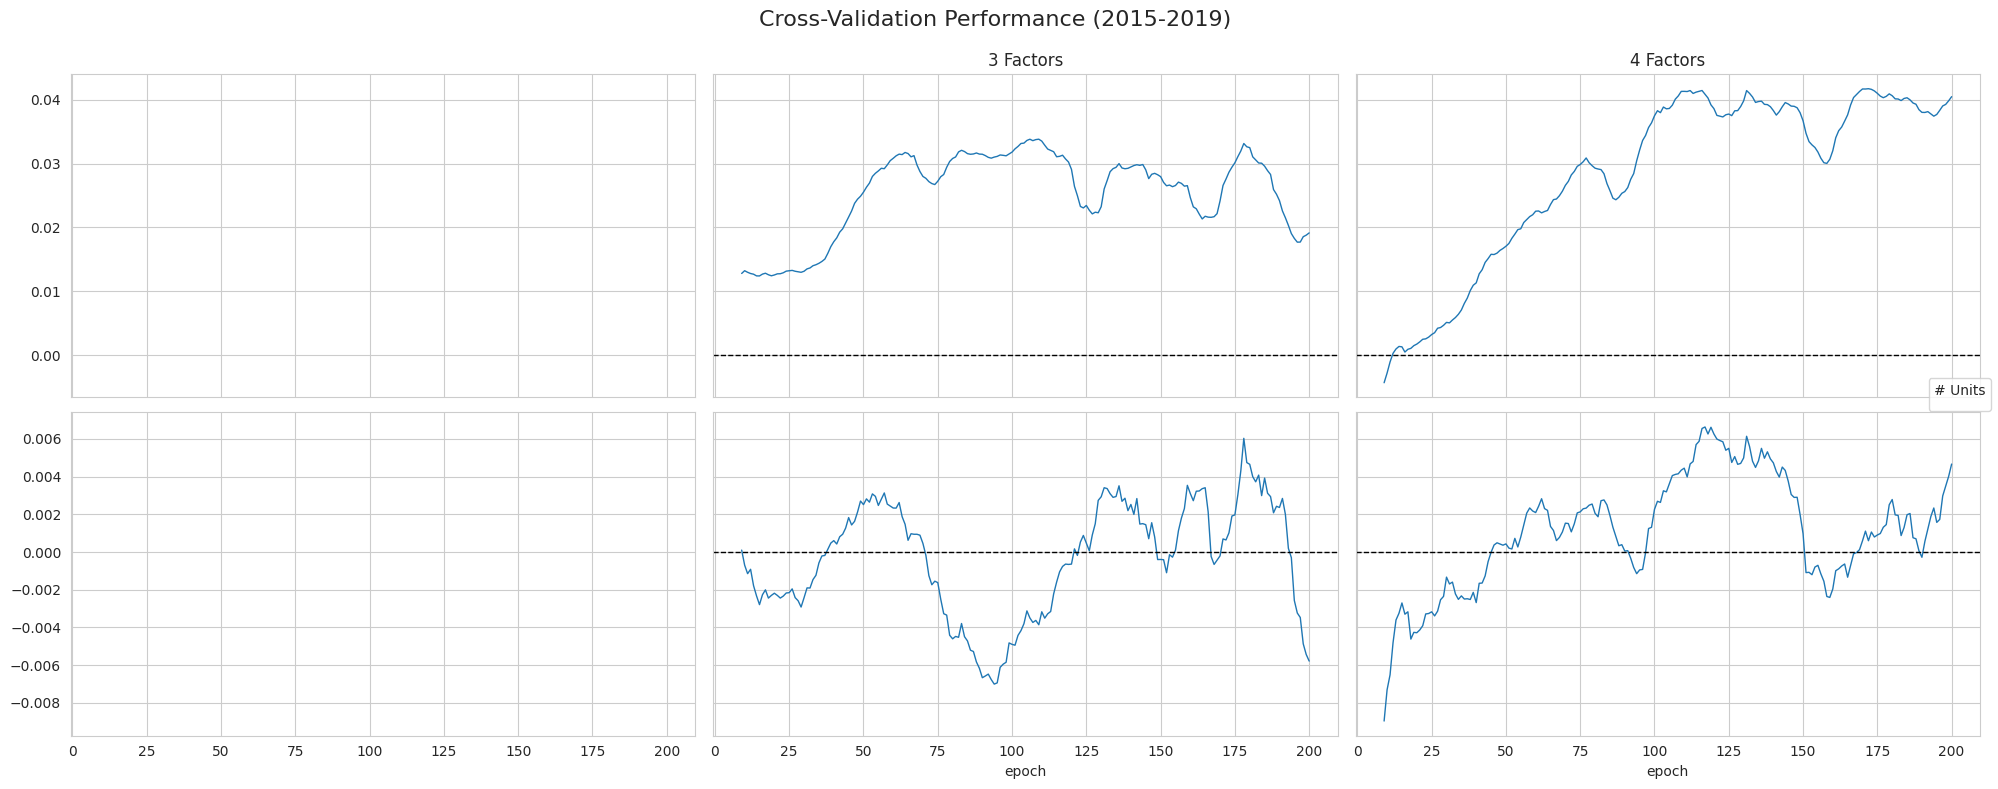

In [ ]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(20, 8), sharey='row', sharex=True)

for n in range(3, 5):
    df = avg[avg.n_factors==n].pivot(index='epoch', columns='units', values='ic_mean')
    df.rolling(10).mean().loc[:200].plot(ax=axes[0][n-2], lw=1, title=f'{n} Factors')
    axes[0][n-2].axhline(0, ls='--', c='k', lw=1)
    axes[0][n-2].get_legend().remove()
    axes[0][n-2].set_ylabel('IC (10-epoch rolling mean)')

    df = avg[avg.n_factors==n].pivot(index='epoch', columns='units', values='ic_daily_median')
    df.rolling(10).mean().loc[:200].plot(ax=axes[1][n-2], lw=1)
    axes[1][n-2].axhline(0, ls='--', c='k', lw=1)
    axes[1][n-2].get_legend().remove()
    axes[1][n-2].set_ylabel('IC, Daily Median (10-epoch rolling mean)')

handles, labels = axes[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', title='# Units')
fig.suptitle('Cross-Validation Performance (2015-2019)', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=.9)
fig.savefig(results_path / 'cv_performance', dpi=300);

## Generate Predictions

We'll average over a range of epochs that appears to deliver good predictions.

In [ ]:
n_factors = 4
units = 8
batch_size = 16
first_epoch = 50
last_epoch = 80

In [ ]:
predictions = []
for epoch in tqdm(list(range(first_epoch, last_epoch))):
    epoch_preds = []
    for fold, (train_idx, val_idx) in enumerate(cv.split(data)):
        X1_train, X2_train, y_train, X1_val, X2_val, y_val = get_train_valid_data(data,
                                                                                  train_idx,
                                                                                  val_idx)
        model.fit([X1_train, X2_train], y_train,
                  batch_size=batch_size,
                  epochs=epoch,
                  verbose=0,
                  shuffle=True)
        epoch_preds.append(pd.Series(model.predict([X1_val, X2_val]).reshape(-1),
                                     index=y_val.stack().index).to_frame(epoch))

    predictions.append(pd.concat(epoch_preds))

  0%|          | 0/30 [00:00<?, ?it/s]

2/2 [==============================] - 0s 12ms/step


  3%|▎         | 1/30 [01:08<33:10, 68.65s/it]

2/2 [==============================] - 0s 8ms/step


  7%|▋         | 2/30 [02:07<29:22, 62.96s/it]

2/2 [==============================] - 0s 9ms/step


 10%|█         | 3/30 [03:06<27:31, 61.18s/it]

2/2 [==============================] - 0s 10ms/step


 13%|█▎        | 4/30 [04:06<26:13, 60.53s/it]

2/2 [==============================] - 0s 8ms/step


 17%|█▋        | 5/30 [05:04<24:54, 59.77s/it]

2/2 [==============================] - 0s 7ms/step


 20%|██        | 6/30 [06:05<24:02, 60.11s/it]

2/2 [==============================] - 0s 9ms/step


 23%|██▎       | 7/30 [07:05<22:58, 59.95s/it]

2/2 [==============================] - 0s 17ms/step


 27%|██▋       | 8/30 [08:06<22:11, 60.54s/it]

2/2 [==============================] - 0s 7ms/step


 30%|███       | 9/30 [09:02<20:40, 59.08s/it]

2/2 [==============================] - 0s 7ms/step


 33%|███▎      | 10/30 [10:03<19:51, 59.56s/it]

2/2 [==============================] - 0s 9ms/step


 37%|███▋      | 11/30 [11:07<19:18, 60.96s/it]

2/2 [==============================] - 0s 9ms/step


 40%|████      | 12/30 [12:05<18:01, 60.10s/it]

2/2 [==============================] - 0s 8ms/step


 43%|████▎     | 13/30 [13:08<17:15, 60.90s/it]

2/2 [==============================] - 0s 8ms/step


 47%|████▋     | 14/30 [14:15<16:44, 62.79s/it]

2/2 [==============================] - 0s 10ms/step


 50%|█████     | 15/30 [15:19<15:49, 63.30s/it]

2/2 [==============================] - 0s 9ms/step


 53%|█████▎    | 16/30 [16:25<14:55, 63.95s/it]

2/2 [==============================] - 0s 8ms/step


 57%|█████▋    | 17/30 [17:27<13:42, 63.30s/it]

2/2 [==============================] - 0s 9ms/step


 60%|██████    | 18/30 [18:34<12:55, 64.59s/it]

2/2 [==============================] - 0s 11ms/step


 63%|██████▎   | 19/30 [19:45<12:09, 66.36s/it]

2/2 [==============================] - 0s 7ms/step


 67%|██████▋   | 20/30 [20:53<11:08, 66.85s/it]

2/2 [==============================] - 0s 11ms/step


 70%|███████   | 21/30 [22:00<10:02, 66.91s/it]

2/2 [==============================] - 0s 8ms/step


 73%|███████▎  | 22/30 [23:10<09:02, 67.82s/it]

2/2 [==============================] - 0s 8ms/step


 77%|███████▋  | 23/30 [24:18<07:56, 68.08s/it]

2/2 [==============================] - 0s 8ms/step


 80%|████████  | 24/30 [25:29<06:52, 68.70s/it]

2/2 [==============================] - 0s 7ms/step


 83%|████████▎ | 25/30 [26:39<05:46, 69.34s/it]

2/2 [==============================] - 0s 10ms/step


 87%|████████▋ | 26/30 [28:10<05:03, 75.80s/it]

2/2 [==============================] - 0s 8ms/step


 90%|█████████ | 27/30 [29:22<03:43, 74.58s/it]

2/2 [==============================] - 0s 7ms/step


 93%|█████████▎| 28/30 [30:54<02:39, 79.86s/it]

2/2 [==============================] - 0s 7ms/step


 97%|█████████▋| 29/30 [33:07<01:35, 95.78s/it]

2/2 [==============================] - 0s 8ms/step


100%|██████████| 30/30 [35:00<00:00, 70.00s/it] 


In [ ]:
predictions_combined = pd.concat(predictions, axis=1).sort_index()   

In [ ]:
predictions_combined.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 596700 entries, (Timestamp('2017-01-06 00:00:00'), 'A') to (Timestamp('2019-12-27 00:00:00'), 'ZYXI')
Data columns (total 30 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   50      596700 non-null  float32
 1   51      596700 non-null  float32
 2   52      596700 non-null  float32
 3   53      596700 non-null  float32
 4   54      596700 non-null  float32
 5   55      596700 non-null  float32
 6   56      596700 non-null  float32
 7   57      596700 non-null  float32
 8   58      596700 non-null  float32
 9   59      596700 non-null  float32
 10  60      596700 non-null  float32
 11  61      596700 non-null  float32
 12  62      596700 non-null  float32
 13  63      596700 non-null  float32
 14  64      596700 non-null  float32
 15  65      596700 non-null  float32
 16  66      596700 non-null  float32
 17  67      596700 non-null  float32
 18  68      596700 non-null  float32
 19  69      5967

In [ ]:
predictions_combined.to_hdf(results_path / 'predictions.h5', 'predictions')